In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_turbulence_1d

In [2]:
seed = 2
N = 100
T = 0.8

configs = {
    "p0": dict(riemann_solver="llf", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="llf", p=1, MUSCL=True, MUSCL_limiter="minmod", flux_recipe=2
    ),
    "ZS3": dict(
        riemann_solver="llf",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="llf",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx"),
        cascade="muscl",
        MUSCL_limiter="minmod",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None)},
    ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_turbulence_1d, seed=seed, M=10, h=1 / N),
        isothermal=True,
        nx=N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True)
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #314 @ t=8.04e-01 | dt=4.20e-03 | min(rho)=8.75e-01, min(P)=8.75e-01 | (done)                  
Running simulation: MUSCL-Hancock
Step #331 @ t=8.02e-01 | dt=4.33e-03 | min(rho)=8.24e-01, min(P)=8.24e-01 | (done)                  
Running simulation: ZS3
Step #332 @ t=8.01e-01 | dt=4.38e-03 | min(rho)=8.08e-01, min(P)=8.08e-01 | (done)                  
Running simulation: MM3
Step #330 @ t=8.03e-01 | dt=4.36e-03 | min(rho)=8.22e-01, min(P)=8.22e-01 | (done)                  


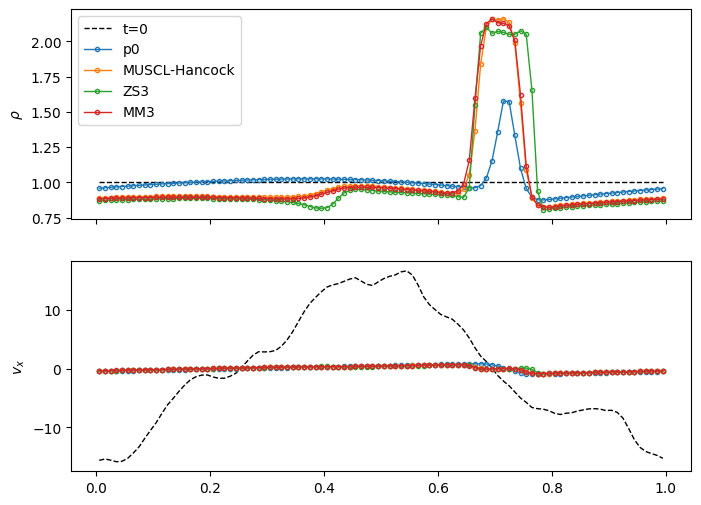

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

plot_1d_slice(sims["p0"], axs[0], "rho", t=0, label="t=0", **style0)
plot_1d_slice(sims["p0"], axs[1], "vx", t=0, label="t=0", **style0)

for name, sim in sims.items():
    plot_1d_slice(sim, axs[0], "rho", label=name, **style1)
    plot_1d_slice(sim, axs[1], "vx", label=name, **style1)
axs[0].legend()